# ECommerce_Text

## Project Overview

This project will use unsupervised methods to group textual product descriptions from E-commerce websites. The data are from this Kaggle dataset: https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification . The data are all labeled with 4 classes: "Electronics", "Household", "Books" and "Clothing & Accessories". So the dataset is suitable for a supervised multiclass classification task. However we will apply unsupervised clustering methods to see how well we can group the text descriptions into the appropriate product categories.

## Project Organization

## Data Loading and Exploratory Data Analysis

In [1]:
import gensim
import nltk
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Read the data set from a CSV file
## There is no header row in the input file.
## The first column is the label or Product_Category, and the 2nd column is
## the product and description as a string.
df = pd.read_csv('./data/ecommerceDataset.csv',header=None)

df.columns=['product_category','raw_text']
df

,product_category,raw_text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...
...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."


In [3]:
## Count the occurences of each product category
df['product_category'].value_counts()

Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: product_category, dtype: int64

### Data Cleaning 


The data has no missing values, but the product descriptions are free-form text. We plan to use scikit-learn TF-IDF to extract features from each product description. But the first steps are to convert all the text to lower case, remove all punctuation and non-alphabetic characters, and remove English stop words.

In [4]:
match_non_alpha = re.compile(r'[^-a-z]+')

def clean_words(text):
    """
    1) Change all text to lower case.
    2) Substitute space for all non-alphabetic characters (allow hyphen to remain)
    3) Split into word tokens and drop English stop words (using ENGLISH_STOP_WORDS from sklearn.feature_extraction.text
    4) Remove single letter tokens
    4) Return a string which concatenates all remaining words in each text.
    """
    text2 = match_non_alpha.sub(r' ',text.lower())
    tokens = text2.split(' ')
    cleaned = []
    for token in tokens:
        ## Also remove single letter tokens, 
        ## Also remove English stop words from scikit-learn feature_extraction
        if len(token) > 1 and token not in ENGLISH_STOP_WORDS:
            cleaned.append(token)
    clean_text = ' '.join(cleaned)
    return clean_text
        
## function to count words in text
def count_words(text):
    return len (text.split(' '))

In [5]:
df['cleaned_text'] = df['raw_text'].apply(clean_words)
df

,product_category,raw_text,cleaned_text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch inch spec...
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gifts india wooden happy birthday u...
...,...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...,strontium microsd class gb memory card black m...
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...,crossbeats wave waterproof bluetooth wireless ...
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...,karbonn titanium wind white karbonn titanium w...
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",samsung guru fm plus sm-b black colour black c...


In [6]:
df['word_counts'] = df['cleaned_text'].apply(count_words)
df

,product_category,raw_text,cleaned_text,word_counts
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...,121
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch inch spec...,36
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...,114
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...,92
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gifts india wooden happy birthday u...,91
...,...,...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...,strontium microsd class gb memory card black m...,57
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...,crossbeats wave waterproof bluetooth wireless ...,11
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...,karbonn titanium wind white karbonn titanium w...,153
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",samsung guru fm plus sm-b black colour black c...,201


In [7]:
df['word_counts'].describe()

count    50425.000000
mean        69.289479
std         84.336362
min          1.000000
25%         24.000000
50%         49.000000
75%         91.000000
max       4016.000000
Name: word_counts, dtype: float64

In [8]:
## It turns out that after removing stop words and puctuation, etc, 
## A few of the cleaned_text values are empty. We will drop these rows
## from the data frame.

df[df['cleaned_text']=='']

,product_category,raw_text,cleaned_text,word_counts
21375,Books,281 and Beyond,,1
23178,Books,281 and Beyond,,1
23976,Books,281 and Beyond,,1
27423,Books,Becoming,,1
30549,Books,Becoming,,1
39330,Clothing & Accessories,,,1


In [9]:
df=df[df['cleaned_text']!='']
df

,product_category,raw_text,cleaned_text,word_counts
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...,121
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch inch spec...,36
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...,114
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...,92
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gifts india wooden happy birthday u...,91
...,...,...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...,strontium microsd class gb memory card black m...,57
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...,crossbeats wave waterproof bluetooth wireless ...,11
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...,karbonn titanium wind white karbonn titanium w...,153
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",samsung guru fm plus sm-b black colour black c...,201


In [10]:
## Descriptive statistics for word counts in the cleaned product descriptions
df['word_counts'].describe()

count    50419.000000
mean        69.297606
std         84.338090
min          1.000000
25%         24.000000
50%         49.000000
75%         91.000000
max       4016.000000
Name: word_counts, dtype: float64

In [11]:
## Create a list of all (cleaned) words used in the product descriptions
## and identify the 50 most frequently occuring words
corpus = list(df['cleaned_text'])

all_words = []
for text in corpus:
    all_words.extend(text.split(' '))
    
print(f'Total Words in the corpus = {len(all_words)}')

all_word_series = pd.Series(all_words)
display(all_word_series.describe())
    
top_50 = pd.DataFrame(
    Counter(all_words).most_common(50),
    columns=['word', 'frequency']
)

top_50

Total Words in the corpus = 3493916


count     3493916
unique      76577
top          size
freq        13063
dtype: object

,word,frequency
0,size,13063
1,book,12658
2,use,12166
3,set,12136
4,easy,11476
5,quality,11215
6,product,10963
7,black,10813
8,home,10496
9,design,10357


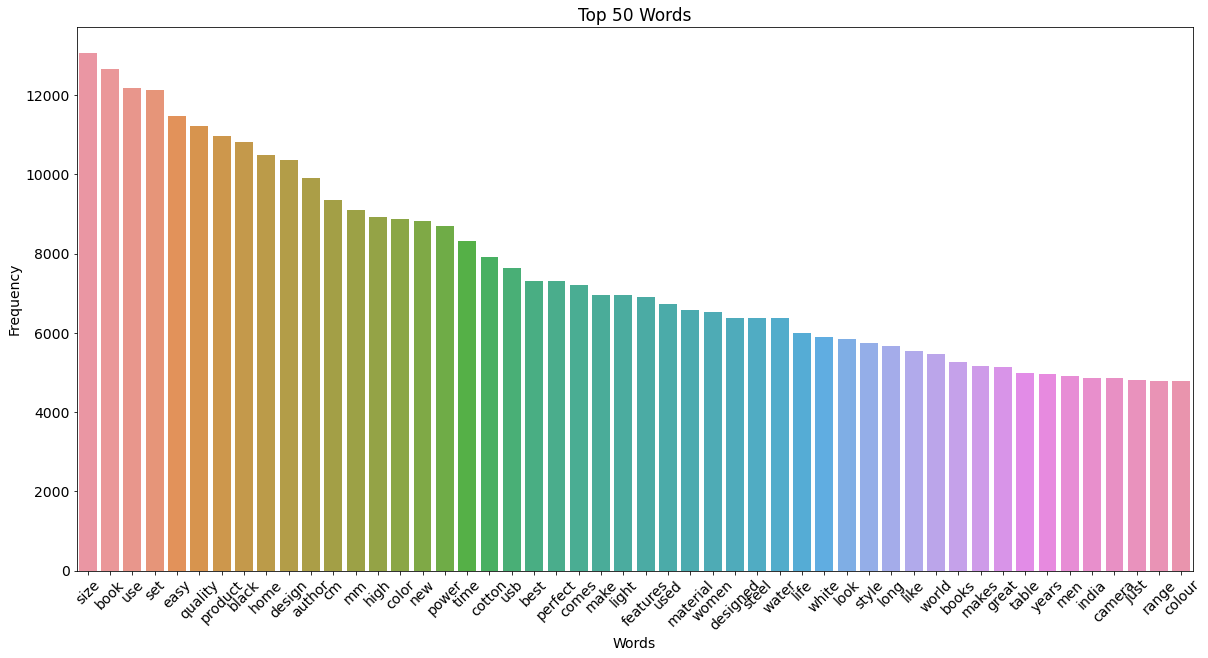

In [12]:
# Plot a bar chart for the top 50 most frequently occuring words
fig = plt.figure(figsize=(20,10))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_50,
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 50 Words', fontsize=17)

plt.show()

# Feature Creation using scikit-learn TF-IDF


We will be using <b>TF-IDF</b> or Term Frequency - Inverse Document Frequency as a way to encode features from the collections of words in each document (product description). The <b>corpus</b> is the set of all words appearing in all documents being considered. A <b>term</b> is a word that appears in the corpus, or a short sequence of specific words. When sequences of words are considered they are called  <b>n-grams</b>. The NGRAM_RANGE defines the minimum and maximum length of the sequences considered.

The ti=f-idf value is proportial to the number of times a term is used in each specific document, and is weighted lower for terms that appear frequently in many documents in the corpus. Terms that appear frequently in given documents may be strong indications of the topics in the document, but terms that appear frequently across many documement provide little specific information.

The scikit-learn TfidfVectorizer determines the frequency of all the terms in the corpus across all documents and across
each specific document being considered. The N most frequent terms in the corpus are used to define a fixed length vector.
This vector is computed for each specific document by computing the tf-idf value of that term in that document for each of the  N most frequent terms in the corpus. This results a fixed-length vector encoding for the collection of words in each document.


In [13]:
%%time

MAX_FEATURES = 10000 ## Build a vocabulary using the only the top max_features ordered by term frequency across the corpus.
MIN_DF = 1 ## Minimum Term Frequency Per Document. Ignore terms that appear less than this number of times in a given document
MAX_DF = 0.85 ## Maximum Document Frequency. Ignore terms that appear in more than this proportion of all documents
NGRAM_RANGE = (1,2)

## Create the tf-idf vectors for all the train and test documents as one corpus
tfidf_vectorizer = TfidfVectorizer(
    min_df=MIN_DF,
    max_df=MAX_DF,
    max_features=MAX_FEATURES,
    ngram_range=NGRAM_RANGE,
)

all_docs = list(df['cleaned_text'])
tfidf = tfidf_vectorizer.fit_transform(all_docs)

# Save the feature names for later to create topic summaries
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

CPU times: total: 7.12 s
Wall time: 7.13 s


## Matrix Factorization

In [14]:
%%time

NUMBER_OF_CATEGORIES = 4  ## We know that there are 4 product categries.
## We will attempt NMF matrix factorization to infer a weight for each category
## in each document.

MAX_NMF_ITERATIONS = 5000

# Run the nmf model
nmf = NMF(
    n_components=NUMBER_OF_CATEGORIES, ## 4 product categories in these product descriptions
    init='nndsvd',
    max_iter=MAX_NMF_ITERATIONS,
    l1_ratio=0.0,
    solver='cd',
    alpha_W=0.0, 
    alpha_H='same',
    tol=1e-5,
    random_state=42
).fit(tfidf)

CPU times: total: 11.3 s
Wall time: 1.97 s


In [15]:
%%time
document_weights = nmf.transform(tfidf_vectorizer.transform(all_docs))
nmf_components = nmf.components_

print(f'nmf_components.shape = {nmf_components.shape}')
print(f'document_weights.shape = {document_weights.shape}')

nmf_components.shape = (4, 10000)
document_weights.shape = (50419, 4)
CPU times: total: 5.94 s
Wall time: 4.37 s


The original matrix of 50419 documents by 10000 tf-idf weights has been factored (approximately) into the product of two matracies <b>document_weights</b> (50419 by 4 ) times <b>nmf_components</b> (4 by 10000). We want to determine most important terms (by tf-idf weighting) in each of the 4 categories. We will extract the 10 highest weighted terms for each category from the nmf_components matrix.
This can be used as a rough indication of which of the 4 products is in each of the four categories.


In [16]:
TOP_N_TERMS = 10

def top_term_indices(topic, n_top_terms):
    """
    return the indices of the n top terms in each topic
    """
    return topic.argsort()[:-n_top_terms - 1:-1] 

for topic_index, topic in enumerate(nmf_components):
    print(f'topic_index = {topic_index}')
    topic_top_terms = top_term_indices(topic, TOP_N_TERMS)
    ## We have the indices of the top terms in each topic
    ## Now use these indices to create a list of terms for each topic
    top_terms = [ tfidf_feature_names[idx] for idx in topic_top_terms]
    print(top_terms)

topic_index = 0
['usb', 'mm', 'black', 'cm', 'steel', 'bluetooth', 'easy', 'use', 'home', 'high']
topic_index = 1
['content', 'students', 'students receive', 'requirements students', 'exam', 'receive', 'team', 'requirements', 'various', 'books']
topic_index = 2
['cotton', 'women', 'men', 'wear', 'fit', 'fabric', 'shirt', 'set', 'look', 'soft']
topic_index = 3
['book', 'author', 'books', 'review', 'world', 'new', 'university', 'india', 'life', 'times']


In [17]:
## The orginal product categories were...
## Count the occurences of each product category
df['product_category'].value_counts()

Household                 19313
Books                     11815
Electronics               10621
Clothing & Accessories     8670
Name: product_category, dtype: int64

So from the top 10 terms it appears that:
    
topic_index 0 represents Electronics

Topic index 2 represents clothing & accessories

Topic index 3 represents books

The remaining topic index 1 must represent household

In [18]:
topic_index_to_name_map = {0: "Electronics", 1: "Household", 2: "Clothing & Accessories", 3: "Books"}
topic_index_to_name_map

{0: 'Electronics', 1: 'Household', 2: 'Clothing & Accessories', 3: 'Books'}

The document_weights matrix (50419 by 4 )  gives a weighting of each of the 4 possible topics in each document. For classification purposes, we just want to find the strongest weight for each document, and use its index as the index of the topic, to look up the topic name.

In [19]:
predicted_indices = np.argmax(document_weights,axis=1)
predicted_topic_names = [topic_index_to_name_map[idx] for idx in predicted_indices]
# print(predicted_topic_names)

In [20]:
## We can add the predicted topic names to a data frame along side the true labels
df2 = pd.DataFrame({'product_category': df['product_category'], 'predicted_topic': predicted_topic_names})
df2

## We can the compute the accuracy of the NMF predicted topics against the true prodocut categories

accuracy = np.sum(df2['product_category']==df2['predicted_topic'])/len(df)
print(f'Accuracy: {accuracy:.4f}')

0.5696


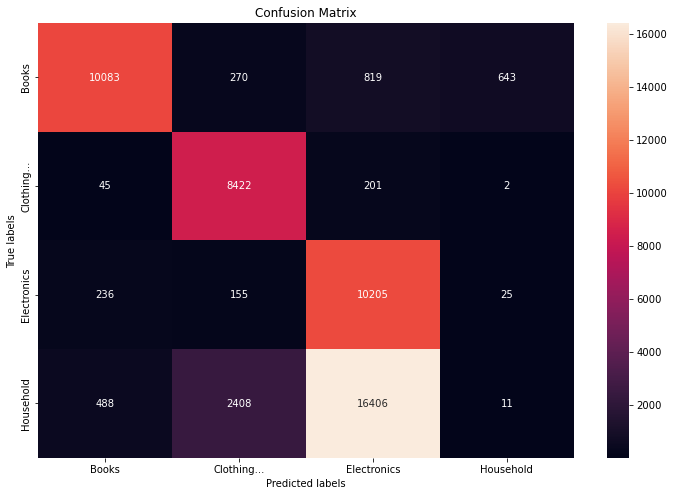

In [21]:
# display confusion matrix here 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
label_names = ['Books','Clothing...','Electronics','Household']
cm = confusion_matrix(df2['product_category'], df2['predicted_topic'])
fig = plt.figure(figsize=(12,8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names); 
ax.yaxis.set_ticklabels(label_names);

In [22]:
df['product_category'].value_counts()

Household                 19313
Books                     11815
Electronics               10621
Clothing & Accessories     8670
Name: product_category, dtype: int64

In [23]:
print ( f'''Fraction of Electronics + Clothing + Books classified correctly: { (10083 + 8422 + 10205)/(50419 - 19313) :.4f}''' )
print ( f'Household items error rate: {1 - 11/19313 :.4f}' )

Fraction of Electronics + Clothing + Books classified correctly: 0.9230
Household items error rate: 0.9994


## 57% Accuracy, so what went wrong?

Examining the confusion matix above we can see that a large majority of the products in in Books, Clothing, and Electronics categories were correctly grouped with other products of the same type. However 99.94% of the Household items were misclassified into the remaining 3 categories. Most of the Household items went with with Electronics. Perhaps there is not enough distinctive information in these product descriptions to separate household from other types of items with an unsupervised algorithm.

# Try KMeans Clustering

In [29]:
%%time

from scipy.cluster.vq import kmeans, whiten

display(type(tfidf))
tfidf_matrix = tfidf.todense()
display(type(tfidf_matrix))

## whiten function normalizes a group of observations. 
## Each feature is divided by its standard deviation across all observations to give it unit variance
features = whiten(tfidf_matrix)
display(features.shape)

num_clusters = 4 ## four product categories

cluster_centers, distortion = kmeans(features, num_clusters)



scipy.sparse.csr.csr_matrix

numpy.matrix

(50419, 10000)

CPU times: total: 14min 54s
Wall time: 4min 57s


In [32]:
# Generate terms from the tfidf_vectorizer object
terms = tfidf_vectorizer.get_feature_names_out()
num_clusters = 4 ## four product categories

for i in range(num_clusters):
    # Sort the terms and print top 10 terms
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(f'index: {i} terms: {sorted_terms[:10]}')

index: 0 terms: ['cotton', 'women', 'wear', 'fit', 'fabric', 'men', 'look', 'comfortable', 'soft', 'casual']
index: 1 terms: ['israeli', 'israel', 'foremost', 'spent years', 'personalities', 'secret', 'feb', 'selling books', 'want know', 'arab']
index: 2 terms: ['applied pasting', 'border remove', 'bubbles repeat', 'cure minimum', 'days decal', 'minimum days', 'repeat required', 'apply desired', 'contamination simply', 'required apply']
index: 3 terms: ['use', 'easy', 'high', 'quality', 'author', 'home', 'black', 'product', 'design', 'color']


In [33]:
topic_index_to_name_map = {3: "Electronics", 2: "Household", 0: "Clothing & Accessories", 1: "Books"}
topic_index_to_name_map

{3: 'Electronics', 2: 'Household', 0: 'Clothing & Accessories', 1: 'Books'}

In [37]:
%%time

from scipy.cluster.vq import vq

## vq returns cluster index for each observation, and distance of each obs. to cluster center
code, distance = vq(features, cluster_centers)

## Now that we have an assigned cluster for each product description, and we have the mapping back to product names,
## We can infer the KMeans prediction for each product, and determine accuracy.

CPU times: total: 3.03 s
Wall time: 1.47 s


In [43]:

predicted_topic_names = [topic_index_to_name_map[idx] for idx in code]

df2 = pd.DataFrame({'product_category': df['product_category'], 'predicted_topic': predicted_topic_names})

accuracy = np.sum(df2['product_category']==df2['predicted_topic'])/len(df)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.3621


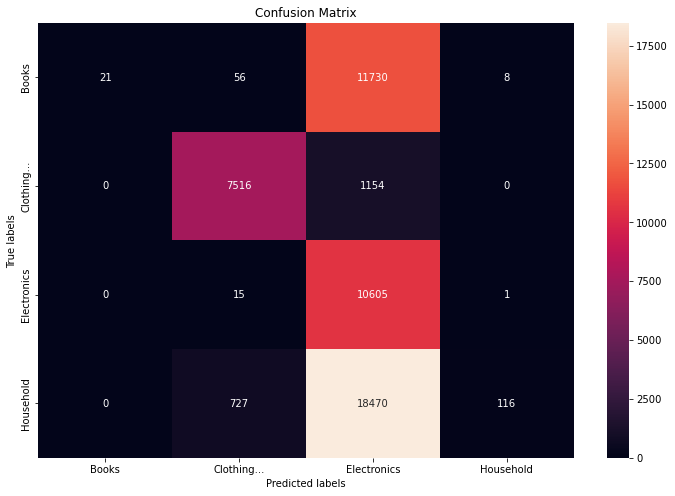

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
label_names = ['Books','Clothing...','Electronics','Household']
cm = confusion_matrix(df2['product_category'], df2['predicted_topic'])
fig = plt.figure(figsize=(12,8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names); 
ax.yaxis.set_ticklabels(label_names);

The KMeans clustering performed much worse than the NMF solution with about 36% accuracy relative to the true labes. From the confusion matrix above it can be seen that KMeans put most of the Clothing into one cluster, but it tended to lump everything else into Electronics.

# Redo NMF Matrix Factorization for just 3 Products: Books, Electronics, and Clothing

In [24]:
df_3prod = df[df['product_category']!='Household']
display(df_3prod['product_category'].describe())
display(df_3prod['product_category'].value_counts())

count     31106
unique        3
top       Books
freq      11815
Name: product_category, dtype: object

Books                     11815
Electronics               10621
Clothing & Accessories     8670
Name: product_category, dtype: int64

In [25]:
## Create a list of all (cleaned) words used in the product descriptions
## and identify the 50 most frequently occuring words
corpus = list(df_3prod['cleaned_text'])

all_words = []
for text in corpus:
    all_words.extend(text.split(' '))
    
print(f'Total Words in the corpus = {len(all_words)}')

all_word_series = pd.Series(all_words)
display(all_word_series.describe())
    
top_50 = pd.DataFrame(
    Counter(all_words).most_common(50),
    columns=['word', 'frequency']
)


Total Words in the corpus = 2189850


count     2189850
unique      61303
top          book
freq        12173
dtype: object

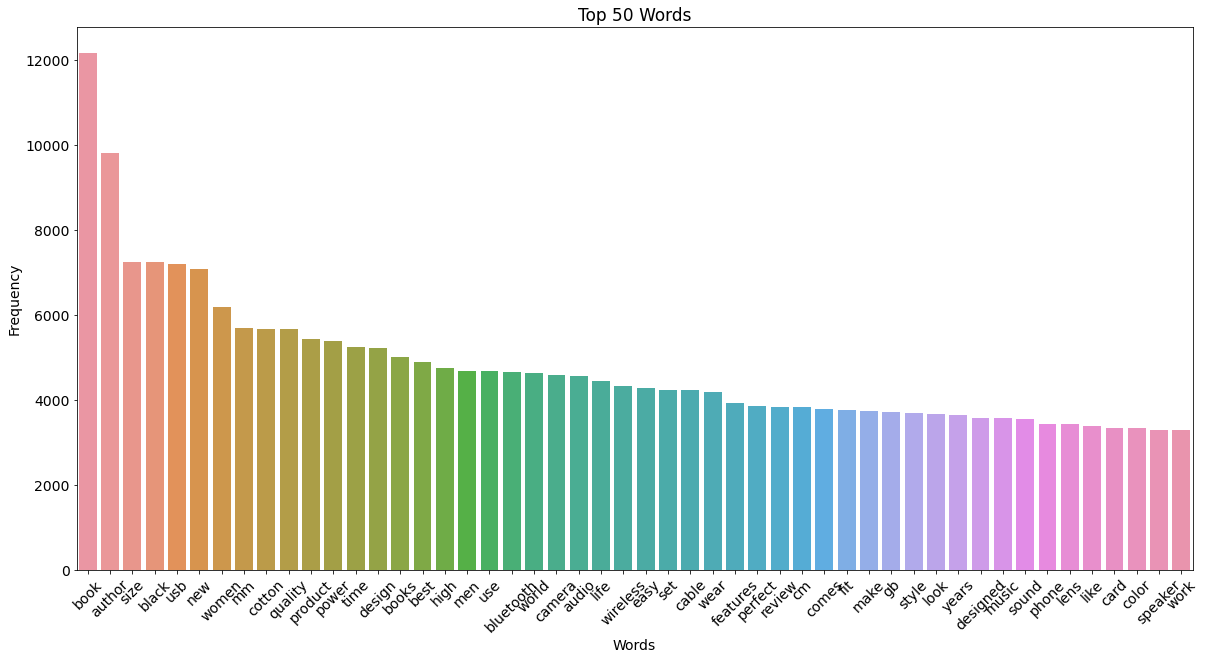

In [26]:
# Plot a bar chart for the top 50 most frequently occuring words
fig = plt.figure(figsize=(20,10))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_50,
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 50 Words', fontsize=17)

plt.show()

## Feature Creation using scikit-learn TF-IDF

In [27]:
%%time

MAX_FEATURES = 10000 ## Build a vocabulary using the only the top max_features ordered by term frequency across the corpus.
MIN_DF = 1 ## Minimum Term Frequency Per Document. Ignore terms that appear less than this number of times in a given document
MAX_DF = 0.85 ## Maximum Document Frequency. Ignore terms that appear in more than this proportion of all documents
NGRAM_RANGE = (1,2)

## Create the tf-idf vectors for all the train and test documents as one corpus
tfidf_vectorizer = TfidfVectorizer(
    min_df=MIN_DF,
    max_df=MAX_DF,
    max_features=MAX_FEATURES,
    ngram_range=NGRAM_RANGE,
)

all_docs = list(df_3prod['cleaned_text'])
tfidf = tfidf_vectorizer.fit_transform(all_docs)

# Save the feature names for later to create topic summaries
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

CPU times: total: 4.66 s
Wall time: 4.68 s


In [39]:
tfidf_vectorizer.get_feature_names_out()

array(['aa', 'aa aaa', 'aa batteries', ..., 'zoook rocker', 'zotac', 'zx'],
      dtype=object)

## Matrix Factorization

In [28]:
%%time

NUMBER_OF_CATEGORIES = 3  ## We know that there 3 remaining product categories in this data subset
## We will attempt NMF matrix factorization to infer a weight for each category
## in each document.

MAX_NMF_ITERATIONS = 5000

# Run the nmf model
nmf = NMF(
    n_components=NUMBER_OF_CATEGORIES, ## 3 product categories in these product descriptions
    init='nndsvd',
    max_iter=MAX_NMF_ITERATIONS,
    l1_ratio=0.0,
    solver='cd',
    alpha_W=0.0, 
    alpha_H='same',
    tol=1e-5,
    random_state=42
).fit(tfidf)

CPU times: total: 9.22 s
Wall time: 1.6 s


In [29]:
%%time
document_weights = nmf.transform(tfidf_vectorizer.transform(all_docs))
nmf_components = nmf.components_

print(f'nmf_components.shape = {nmf_components.shape}')
print(f'document_weights.shape = {document_weights.shape}')

nmf_components.shape = (3, 10000)
document_weights.shape = (31106, 3)
CPU times: total: 4.3 s
Wall time: 3.09 s


The matrix of 31106 documents by 10000 tf-idf weights has been factored (approximately) into the product of two matracies <b>document_weights</b> (31106 by 3 ) times <b>nmf_components</b> (3 by 10000). We want to determine most important terms (by tf-idf weighting) in each of the 3 categories. We will extract the 10 highest weighted terms for each category from the nmf_components matrix.

This can be used as a rough indication of which of the 3 remaining products is in each of the 3 categories.

In [30]:
TOP_N_TERMS = 10

def top_term_indices(topic, n_top_terms):
    """
    return the indices of the n top terms in each topic
    """
    return topic.argsort()[:-n_top_terms - 1:-1] 

for topic_index, topic in enumerate(nmf_components):
    print(f'topic_index = {topic_index}')
    topic_top_terms = top_term_indices(topic, TOP_N_TERMS)
    ## We have the indices of the top terms in each topic
    ## Now use these indices to create a list of terms for each topic
    top_terms = [ tfidf_feature_names[idx] for idx in topic_top_terms]
    print(top_terms)

topic_index = 0
['usb', 'bluetooth', 'audio', 'wireless', 'mm', 'gb', 'cable', 'speaker', 'music', 'black']
topic_index = 1
['content', 'students', 'book', 'students receive', 'requirements students', 'exam', 'receive', 'team', 'books', 'requirements']
topic_index = 2
['cotton', 'women', 'men', 'wear', 'fit', 'fabric', 'shirt', 'look', 'set', 'girls']


In [31]:
topic_index_to_name_map = {0: "Electronics", 1: "Books", 2: "Clothing & Accessories"}
topic_index_to_name_map

{0: 'Electronics', 1: 'Books', 2: 'Clothing & Accessories'}

The document_weights matrix (31106 by 3 )  gives a weighting of each of the 3 possible topics in each document. For classification purposes, we just want to find the strongest weight for each document, and use its index as the index of the topic, to look up the topic name.

In [32]:
predicted_indices = np.argmax(document_weights,axis=1)
predicted_topic_names = [topic_index_to_name_map[idx] for idx in predicted_indices]
# print(predicted_topic_names)

In [36]:
## We can add the predicted topic names to a data frame along side the true labels
df2 = pd.DataFrame({'product_category': df_3prod['product_category'], 'predicted_topic': predicted_topic_names})
df2

## We can the compute the accuracy of the NMF predicted topics against the true prodocut categories

accuracy = np.sum(df2['product_category']==df2['predicted_topic'])/len(df_3prod)
print(f'{accuracy:.4f}')

0.8218


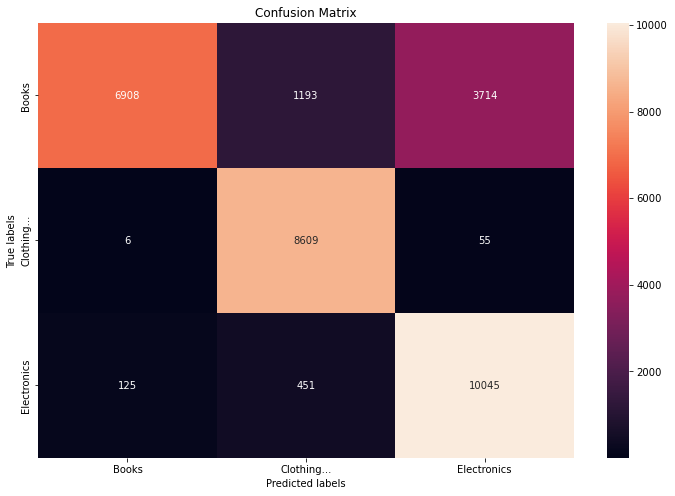

In [37]:
# display confusion matrix here 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
label_names = ['Books','Clothing...','Electronics']
cm = confusion_matrix(df2['product_category'], df2['predicted_topic'])
fig = plt.figure(figsize=(12,8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names); 
ax.yaxis.set_ticklabels(label_names);

The NMF factorization using just 3 products was somewhat more accurate at 82%, compared to 57% when trying to cluster 4 products. But from the confusion matrix above it can be seen that a substantial chunk of the Books are now lumped in with Electronics.